In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

class LetterCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.out = nn.Linear(in_features=84, out_features=3)

    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = t.reshape(-1, 16 * 5 * 5)
        t = self.fc1(t)
        t = F.relu(t)

        t = self.fc2(t)
        t = F.relu(t)

        t = self.out(t)
        return t

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

test_dir = "test"
weights_path = "best.pth"


test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False
)

idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}


model = LetterCNN().to(device)
state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Классы:", test_dataset.classes)
print("Всего изображений:", len(test_dataset))

Классы: ['p', 'sh', 't']
Всего изображений: 3


test\p\1.jpg
  real: p
  pred: t
----------------------------------------


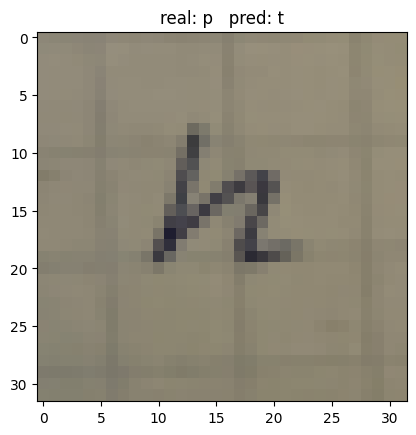

test\sh\1.jpg
  real: sh
  pred: sh
----------------------------------------


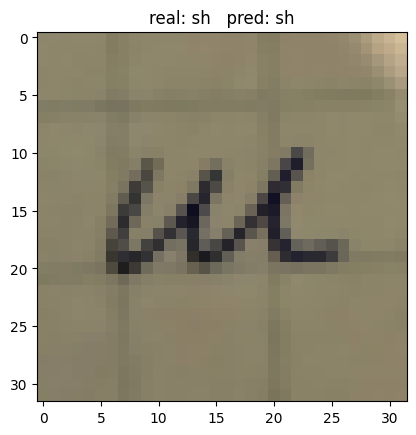

test\t\1.jpg
  real: t
  pred: t
----------------------------------------


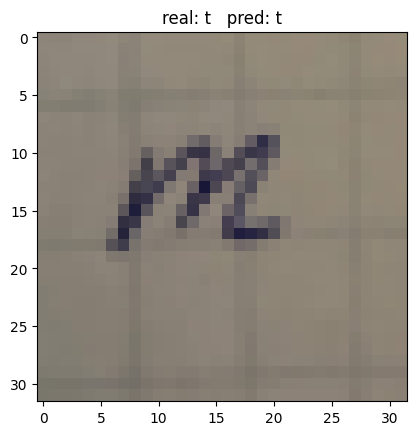

In [28]:
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = outputs.max(1)

        true_idx = labels.item()
        pred_idx = preds.item()

        true_class = idx_to_class[true_idx]
        pred_class = idx_to_class[pred_idx]

        img_path, _ = test_dataset.samples[i]

        print(f"{img_path}")
        print(f"  real: {true_class}")
        print(f"  pred: {pred_class}")
        print("-" * 40)

        # ============ ПОДГОТОВКА КАРТИНКИ ДЛЯ ПОКАЗА ============

        # берем тензор уже после ресайза
        img_vis = images[0].detach().cpu()  # [3, 32, 32]

        # в формат HWC для matplotlib
        img_vis = img_vis.permute(1, 2, 0).numpy()

        plt.figure()
        plt.imshow(img_vis)
        plt.title(f"real: {true_class}   pred: {pred_class}")
        plt.show()